In [ ]:
import os, time
import collections
import platform
import numpy as np 
import matplotlib.pyplot as plt 
import keras
import warnings;
warnings.filterwarnings('ignore');
import pandas as pd
import tensorflow as tf
from keras.layers import Dense, Dropout, Input
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib.pyplot import cm
from keras.models import Model
from keras.models import Sequential, load_model
from keras.optimizers import SGD 
from keras.utils import to_categorical
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from keras.models import model_from_json
from keras.callbacks import Callback
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_fscore_support
# init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
#load data
output_path = './Results/'
model_path = output_path + "Models/"
data_path = './Data/'
block_data = pd.read_excel(data_path + "allBlockData.xlsx",index_col=0)
slice_data = pd.read_excel(data_path + 'allSliceData.xlsx',index_col=0)

In [3]:
# top ten radiomics features + gender
op = ['GLCM_Imc2', 'GLRLM_RunLengthNonUniformity', 'GLSZM_GrayLevelNonUniformity',
       'GLSZM_GrayLevelVariance', 'WAVELET_LLL_glcm_Idm', 'WAVELET_LLL_glcm_Id','WAVELET_LLH_glcm_Idm', 'WAVELET_LLH_glcm_Id',
       'WAVELET_LLH_glrlm_RunLengthNonUniformity', 'WAVELET_HHH_glrlm_RunEntropy', 'Gender']

In [4]:
# identify the test data
data = block_data.sample(frac=1,random_state=11)
study_frame,test_frame, c,d = train_test_split(data.ix[:,:-1],data.ix[:,-1],stratify=data.ix[:,'IsMS'], test_size=0.2, random_state=9)
block_test = block_data[block_data.ID.isin(test_frame.ID.tolist())]

In [5]:
block_test.ix[:,1:-8] = (block_test.ix[:,1:-8] - block_test.ix[:,1:-8].mean())/block_test.ix[:,1:-8].std()
block_test.reset_index(drop=True, inplace=True)
block_test = block_test.sample(frac=1,random_state=11)
block_test_indexes = block_test.index
block_test.reset_index(drop=True, inplace=True)

In [6]:
# the corresponding slice test data
slice_test = slice_data[slice_data.ID.isin(test_frame.ID.tolist())]
slice_test.ix[:,1:-8] = (slice_test.ix[:,1:-8] - slice_test.ix[:,1:-8].mean())/slice_test.ix[:,1:-8].std()
slice_test.reset_index(drop=True, inplace=True)

In [7]:
def GetSliceTestBatch(data, batch_index):
    indices = []
    for i in range(int(len(data)/10)):
        indices.append(batch_index + i*10)
    test = data.loc[indices]
    test.reset_index(drop=True, inplace=True)
    return test

In [8]:
# targets
ftypes = ['IsMS','IsCO','IsVO','IsCTVO','IsIR']


In [9]:
# load pretrained models and estimate on test data
block_probases = []
slice_probases = []
ensemble_probases = []
y_tests = []

for ftype in ftypes:
    with open(model_path + 'model_block.json', 'r') as json_file:
        loaded_model_json = json_file.read()

    block_model = model_from_json(loaded_model_json)
    print("Loaded block model from disk")
    block_model.load_weights(model_path + ftype[2:] + "_block_model.h5")
    block_probas = block_model.predict(block_test.ix[:,op])
    block_probases.append(block_probas)
        
    with open(output_path + 'model_slice.json', 'r') as json_file:
        loaded_model_json = json_file.read()
  
    slice_model = model_from_json(loaded_model_json)
    print("Loaded slice model from disk")
    slice_model.load_weights(model_path + ftype[2:] + "_slice_model.h5")
    slice_probases_ = []
    ensemble_probases_ = []
    for i in range(10):
        slice_test_batch = GetSliceTestBatch(slice_test, i)    
        batch = slice_test_batch.loc[block_test_indexes].reset_index(drop=True)
        slice_probas = slice_model.predict(batch.ix[:,op])
        ensemble_probases_.append((slice_probas + block_probas)/2)
        slice_probases_.append(slice_probas)

    slice_probases.append(slice_probases_)
    ensemble_probases.append(ensemble_probases_)
    y_tests.append(block_test.ix[:,ftype])
    print('Predicted for ', ftype)

Loaded block model from disk
Loaded slice model from disk
Predicted for  IsMS
Loaded block model from disk
Loaded slice model from disk
Predicted for  IsCO
Loaded block model from disk
Loaded slice model from disk
Predicted for  IsVO
Loaded block model from disk
Loaded slice model from disk
Predicted for  IsCTVO
Loaded block model from disk
Loaded slice model from disk
Predicted for  IsIR


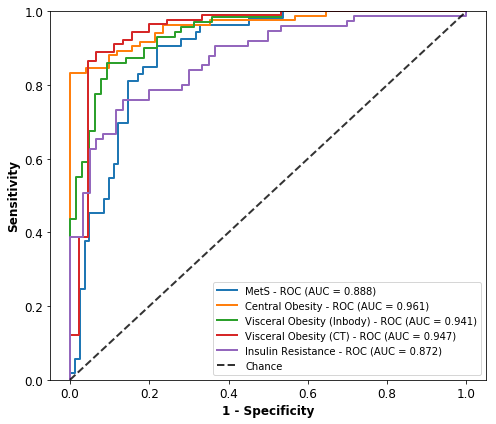

In [14]:
# the ROC/AUC test performance (features extracted from block)
names = ['MetS', 'Central Obesity', 'Visceral Obesity (Inbody)', 'Visceral Obesity (CT)', 'Insulin Resistance']
probases = [block_probases, slice_probases, ensemble_probases]
roc_names = ['block','slice','combined']
plt.rcParams['font.sans-serif']=['Times New Roman']
plt.rcParams['axes.unicode_minus']=False 
ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches( 7, 6)
precision_recall_fscore = []
for i in range(len(ftypes)):
    fpr, tpr, thresholds = roc_curve(y_tests[i],block_probases[i][:, 1])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, alpha=1,
         label=names[i]+' - ROC (AUC = %0.3f)' % (roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
         label='Chance', alpha=.8)

plt.xlim([-0.05, 1.05])
plt.ylim([0, 1.0])

plt.xlabel('1 - Specificity',fontsize=12,fontweight='bold')
plt.ylabel('Sensitivity',fontsize=12,fontweight='bold')
plt.legend(loc="lower right")


ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
plt.tight_layout()
plt.savefig(output_path + 'test_roc_block.svg',format='svg')
plt.show()

In [14]:
# other test metrics (accuracy, precision, f1-score, recall)
names = ['MetS', 'Central Obesity', 'Visceral Obesity (Inbody)', 'Visceral Obesity (CT)', 'Insulin Resistance']
precision_recall_fscore = []
for i in range(len(ftypes)):
        fpr, tpr, thresholds = roc_curve(y_tests[i],block_probases[i][:, 1])
        roc_auc = auc(fpr, tpr)
        prf = precision_recall_fscore_support(y_tests[i], np.argmax(block_probases[i],axis=1) ,average = "weighted")
        ac = accuracy_score(y_tests[i], np.argmax(block_probases[i],axis=1))
        precision_recall_fscore.append([prf[0],prf[1],prf[2],ac,roc_auc])
metrics = pd.DataFrame(np.array(precision_recall_fscore), columns=['Precision','Recall','F1-score','Accuracy','AUC'], index=names)
mean_values = []
for i in range(4):
    mean_values.append(np.mean(np.array(precision_recall_fscore)[:,i]))
metrics.to_excel(output_path + "test_metrics_block.xlsx")
print(metrics)
    
probases = [slice_probases, ensemble_probases]
roc_names = ['slice','combined']

for m in range(len(probases)):
    precision_recall_fscore = []
    stds = []
    for i in range(len(ftypes)):
        tmpMetrics = []
        for j in range(10):
            fpr, tpr, thresholds = roc_curve(y_tests[i],probases[m][i][j][:, 1])
            roc_auc = auc(fpr, tpr)
            prf = precision_recall_fscore_support(y_tests[i], np.argmax(probases[m][i][j],axis=1) ,average = "weighted")
            ac = accuracy_score(y_tests[i], np.argmax(probases[m][i][j],axis=1))
            tmpMetrics.append([prf[0],prf[1],prf[2],ac,roc_auc])
        precision_recall_fscore.append(np.mean(np.array(tmpMetrics), axis=0))
        stds.append(np.std(np.array(tmpMetrics),axis=0))
    metrics = pd.DataFrame(np.array(precision_recall_fscore), columns=['Precision','Recall','F1-score','Accuracy','AUC'], index=names)   
    stda = pd.DataFrame(np.array(stds), columns=['Precision','Recall','F1-score','Accuracy','AUC'], index=names)
    metrics = round(metrics,3)
    stda = round(stda,3)
    for col in metrics.columns:
        metrics[col] = metrics[col].map(str) + '±' + stda[col].map(str)
    print(metrics)
    metrics.to_excel(output_path + "test_metrics_"+roc_names[m]+".xlsx")

                           Precision    Recall  F1-score  Accuracy       AUC
MetS                        0.834241  0.829630  0.830788  0.829630  0.887943
Central Obesity             0.893159  0.888889  0.889781  0.888889  0.961251
Visceral Obesity (Inbody)   0.860713  0.859259  0.858792  0.859259  0.941461
Visceral Obesity (CT)       0.911859  0.911111  0.909370  0.911111  0.947160
Insulin Resistance          0.770645  0.770370  0.768377  0.770370  0.872444
                             Precision       Recall     F1-score     Accuracy  \
MetS                       0.782±0.018  0.778±0.017  0.779±0.017  0.778±0.017   
Central Obesity            0.859±0.009  0.856±0.008  0.857±0.008  0.856±0.008   
Visceral Obesity (Inbody)   0.83±0.009  0.829±0.008  0.828±0.008  0.829±0.008   
Visceral Obesity (CT)      0.884±0.011  0.879±0.012  0.873±0.013  0.879±0.012   
Insulin Resistance         0.776±0.012  0.773±0.012   0.77±0.013  0.773±0.012   

                                   AUC  
MetS      

slice


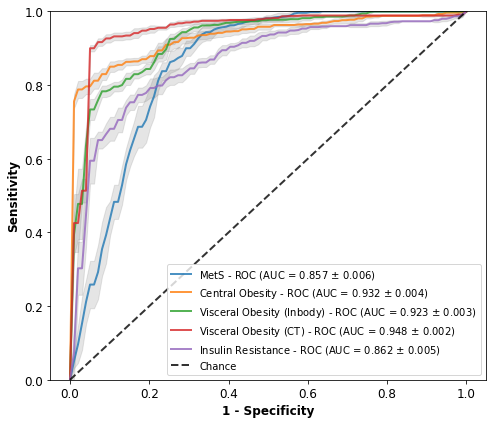

combined


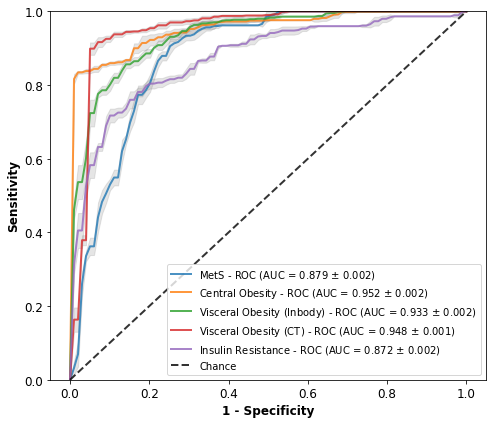

In [13]:
# the ROC/AUC test performance (features extracted from slices)
from scipy import interp

names = ['MetS', 'Central Obesity', 'Visceral Obesity (Inbody)', 'Visceral Obesity (CT)', 'Insulin Resistance']
probases = [slice_probases, ensemble_probases]
roc_names = ['slice','combined']

for m in range(len(probases)):
    print(roc_names[m])
    plt.rcParams['font.sans-serif']=['Times New Roman']
    plt.rcParams['axes.unicode_minus']=False 
    ax = plt.gca()
    fig = plt.gcf()
    fig.set_size_inches(7, 6)

    for k in range(len(ftypes)):
        tprs_rf = []
        aucs_rf = []
        tprs = []
        aucs = []

        mean_fpr = np.linspace(0, 1, 100)
        precision_recall_fscore = []
        auc_values = []

        for i in range(10):
            fpr, tpr, thresholds = roc_curve(y_tests[k], probases[m][k][i][:, 1])
            roc_auc = auc(fpr, tpr)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            aucs.append(roc_auc)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, 
                 label=names[k] + r' - ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc, std_auc),
                 lw=2, alpha=.8)


        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='black',
             label='Chance', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([0, 1.0])

    plt.xlabel('1 - Specificity',fontsize=12,fontweight='bold')
    plt.ylabel('Sensitivity',fontsize=12,fontweight='bold')
    plt.legend(loc="lower right")

    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    plt.tight_layout()
    plt.savefig(output_path + 'test_roc_'+roc_names[m]+'.svg',format='svg')
    plt.show()